In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import cv2
import imgaug.augmenters as iaa
import glob

from cifar import CifarDataset, CifarTestDataset

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x': (-5, 5), 'y':(-5,5)}, mode='wrap'),
    iaa.Affine(rotate=(-5,5), mode='edge'),
    iaa.Dropout2d(p=0.2)
], random_order=True)

dataset = CifarDataset('./data/cifar-10-batches-py', device=device, aug=aug)
raw_test_dataset = CifarTestDataset('./data/cifar-10-batches-py', device=device)
test_dataset, val_dataset = torch.utils.data.random_split(raw_test_dataset, [5000, 5000])
print("training samples: %d" % len(dataset))
print("validation samples: %d" % len(val_dataset))
print("test samples: %d" % len(test_dataset))

training samples: 50000
validation samples: 5000
test samples: 5000


In [3]:
train_loader = DataLoader(dataset, collate_fn=dataset.collate_fn, batch_size=96, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
class ResNetModule(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()
        padding = kernel_size - 2
        expansion = channels * 2
        self.conv = nn.Sequential(
            nn.Conv2d(channels, expansion, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(expansion),
            nn.ReLU(),
            nn.Conv2d(expansion, channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.conv(x) + x
        return out

class SimpleResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.reslayer1 = ResNetModule(64, 3)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.reslayer2 = ResNetModule(64, 3)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        fm = self.conv1(x)
        fm = self.reslayer1(fm)
        fm = self.conv2(fm)
        fm = self.reslayer2(fm)
        fm = self.avgpool(fm)
        result = self.classifier(fm)
        
        return result


# model = nn.Sequential(
#     nn.Conv2d(3, 64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(64, 512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(512, 512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(512, 512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(512, 512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Flatten(),
#     nn.Linear(512, 1024),
#     nn.BatchNorm1d(1024),
#     nn.ReLU(),
#     nn.Linear(1024, 10)
# ).to(device)
model = SimpleResNet().to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True,
    factor=0.2, patience=5, threshold=1e-3, threshold_mode='rel', min_lr=5e-6)
scalar = torch.cuda.amp.GradScaler()

In [5]:
from torchsummary import summary
summary(model, torch.zeros(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
├─ResNetModule: 1-2                      [-1, 64, 32, 32]          --
|    └─Sequential: 2-4                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         73,856
|    |    └─BatchNorm2d: 3-2             [-1, 128, 32, 32]         256
|    |    └─ReLU: 3-3                    [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          73,792
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
├─ResNetModule: 1-2                      [-1, 64, 32, 32]          --
|    └─Sequential: 2-4                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         73,856
|    |    └─BatchNorm2d: 3-2             [-1, 128, 32, 32]         256
|    |    └─ReLU: 3-3                    [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          73,792
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|

In [6]:
def train_batch(x, y, model, lossfn, opt):
    model.train()
    with torch.cuda.amp.autocast():
        yp = model(x)
        loss = lossfn(yp, y)
    
    scalar.scale(loss).backward()
    scalar.step(opt)
    scalar.update()
    opt.zero_grad()
    return loss.item()

@torch.no_grad()
def val_loss(x, y, model, lossfn):
    model.eval()
    with torch.cuda.amp.autocast():
        yp = model(x)
        loss = lossfn(yp, y)
    return loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    yp = model(x).argmax(dim=1)
    is_correct = (y == yp).cpu().numpy().tolist()
    return is_correct

In [7]:
import time
train_losses = []
val_losses = []
val_acces = []

for epoch in range(50):
    start = time.time()

    # training
    epoch_train_losses = []
    for x, y in train_loader:
        loss = train_batch(x, y, model, lossfn, optimizer)
        epoch_train_losses.append(loss)
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    epoch_val_losses = []
    epoch_val_acces = []
    for x, y in val_loader:
        loss = val_loss(x, y, model, lossfn)
        epoch_val_losses.append(loss)
        is_correct = accuracy(x, y, model)
        epoch_val_acces.extend(is_correct)
    epoch_val_loss = np.mean(epoch_val_losses)
    val_losses.append(epoch_val_loss)
    epoch_val_acc = np.mean(epoch_val_acces)
    val_acces.append(epoch_val_acc)
    scheduler.step(epoch_val_loss)

    end = time.time()
    print("epoch %d, %.2fs, trloss: %.2f, valloss: %.2f, valcc: %.2f" %
          (epoch, end-start, epoch_train_loss, epoch_val_loss, epoch_val_acc*100))

test_acces = []
for x, y in test_loader:
    is_correct = accuracy(x, y, model)
    test_acces.extend(is_correct)
test_acc = np.mean(test_acces)
print("======================")
print("final test acc %.2f" % (test_acc*100))
print("======================")


epoch 0, 342.99s, trloss: 1.88, valloss: 1.57, valcc: 39.98
epoch 1, 345.37s, trloss: 1.58, valloss: 1.31, valcc: 51.66
epoch 2, 345.90s, trloss: 1.40, valloss: 1.22, valcc: 54.78
epoch 3, 346.44s, trloss: 1.26, valloss: 1.16, valcc: 57.66
epoch 4, 336.03s, trloss: 1.16, valloss: 1.27, valcc: 56.32
epoch 5, 331.83s, trloss: 1.08, valloss: 0.99, valcc: 64.04
epoch 6, 333.44s, trloss: 1.02, valloss: 1.27, valcc: 56.58
epoch 7, 338.36s, trloss: 0.98, valloss: 1.00, valcc: 65.52
epoch 8, 338.14s, trloss: 0.94, valloss: 1.03, valcc: 63.42
epoch 9, 338.61s, trloss: 0.91, valloss: 0.84, valcc: 69.54
epoch 10, 339.51s, trloss: 0.87, valloss: 1.02, valcc: 65.64
epoch 11, 337.42s, trloss: 0.84, valloss: 1.31, valcc: 58.18
epoch 12, 336.50s, trloss: 0.81, valloss: 1.12, valcc: 64.84
epoch 13, 337.85s, trloss: 0.79, valloss: 0.96, valcc: 68.20
epoch 14, 337.12s, trloss: 0.76, valloss: 0.85, valcc: 70.54
Epoch    16: reducing learning rate of group 0 to 2.0000e-04.
epoch 15, 337.50s, trloss: 0.74, 

KeyboardInterrupt: 

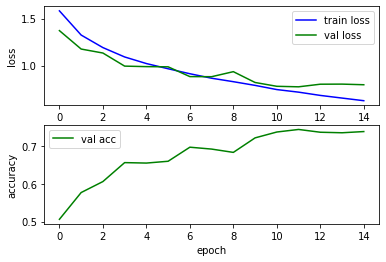

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(train_losses, 'b', label='train loss')
plt.plot(val_losses, 'g', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_acces, 'g', label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

torch.Size([1, 64, 32, 32])

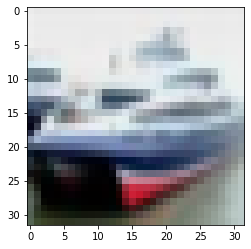

In [ ]:
data = raw_test_dataset.test_x[1]
plt.imshow(data.cpu().permute(1, 2, 0))
first_layer = list(model.children())[0]
first_layer_out = first_layer(data.unsqueeze(0)).detach()
first_layer_out.shape

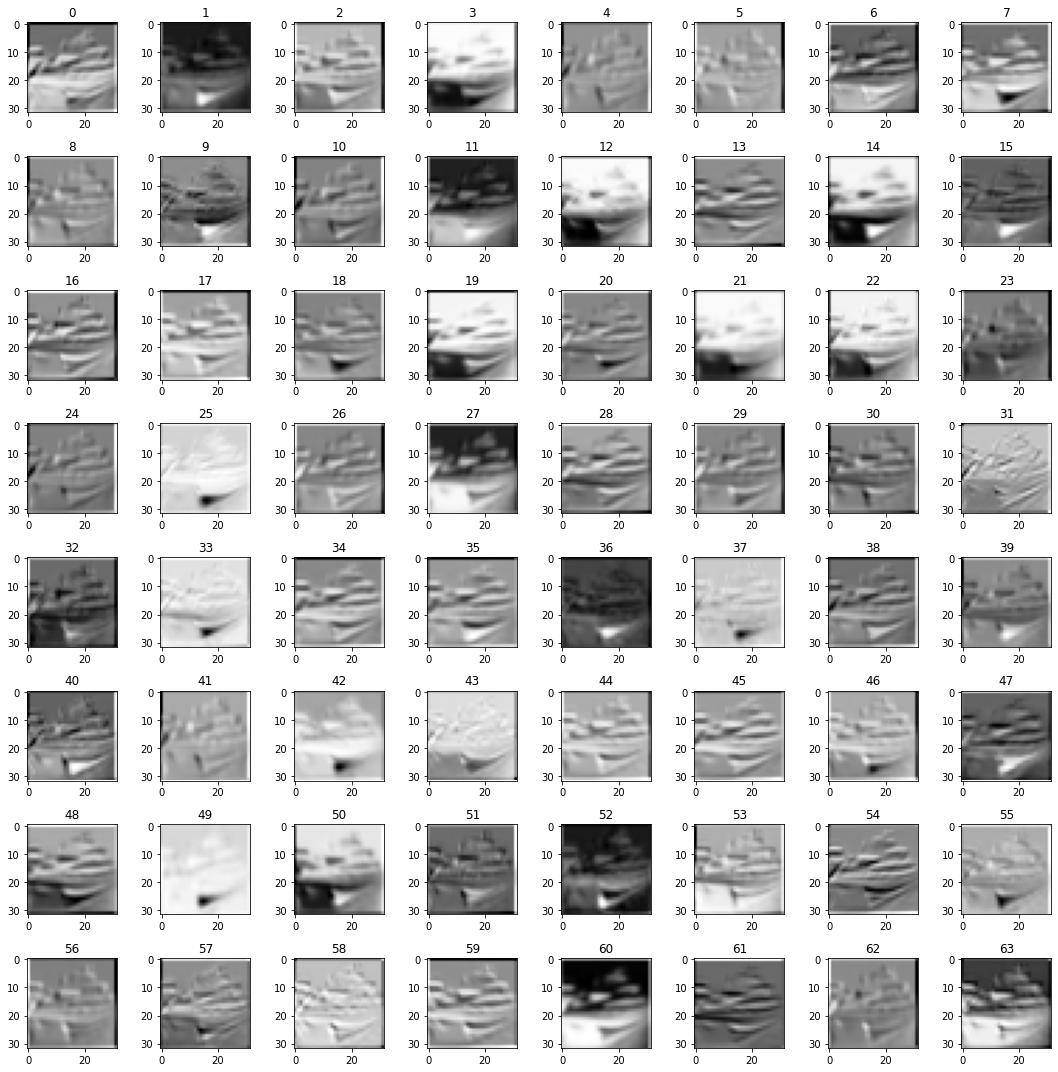

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(first_layer_out[0][i].cpu(), cmap='Greys')
    ax.set_title(str(i))
plt.tight_layout()
plt.show()